<center>

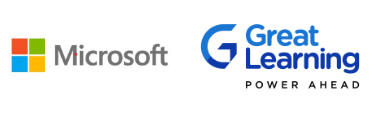
</center>

##**Index:**

1. Setup

2. Pre-processing

3. Extract and Evaluate Output

<p align="right">
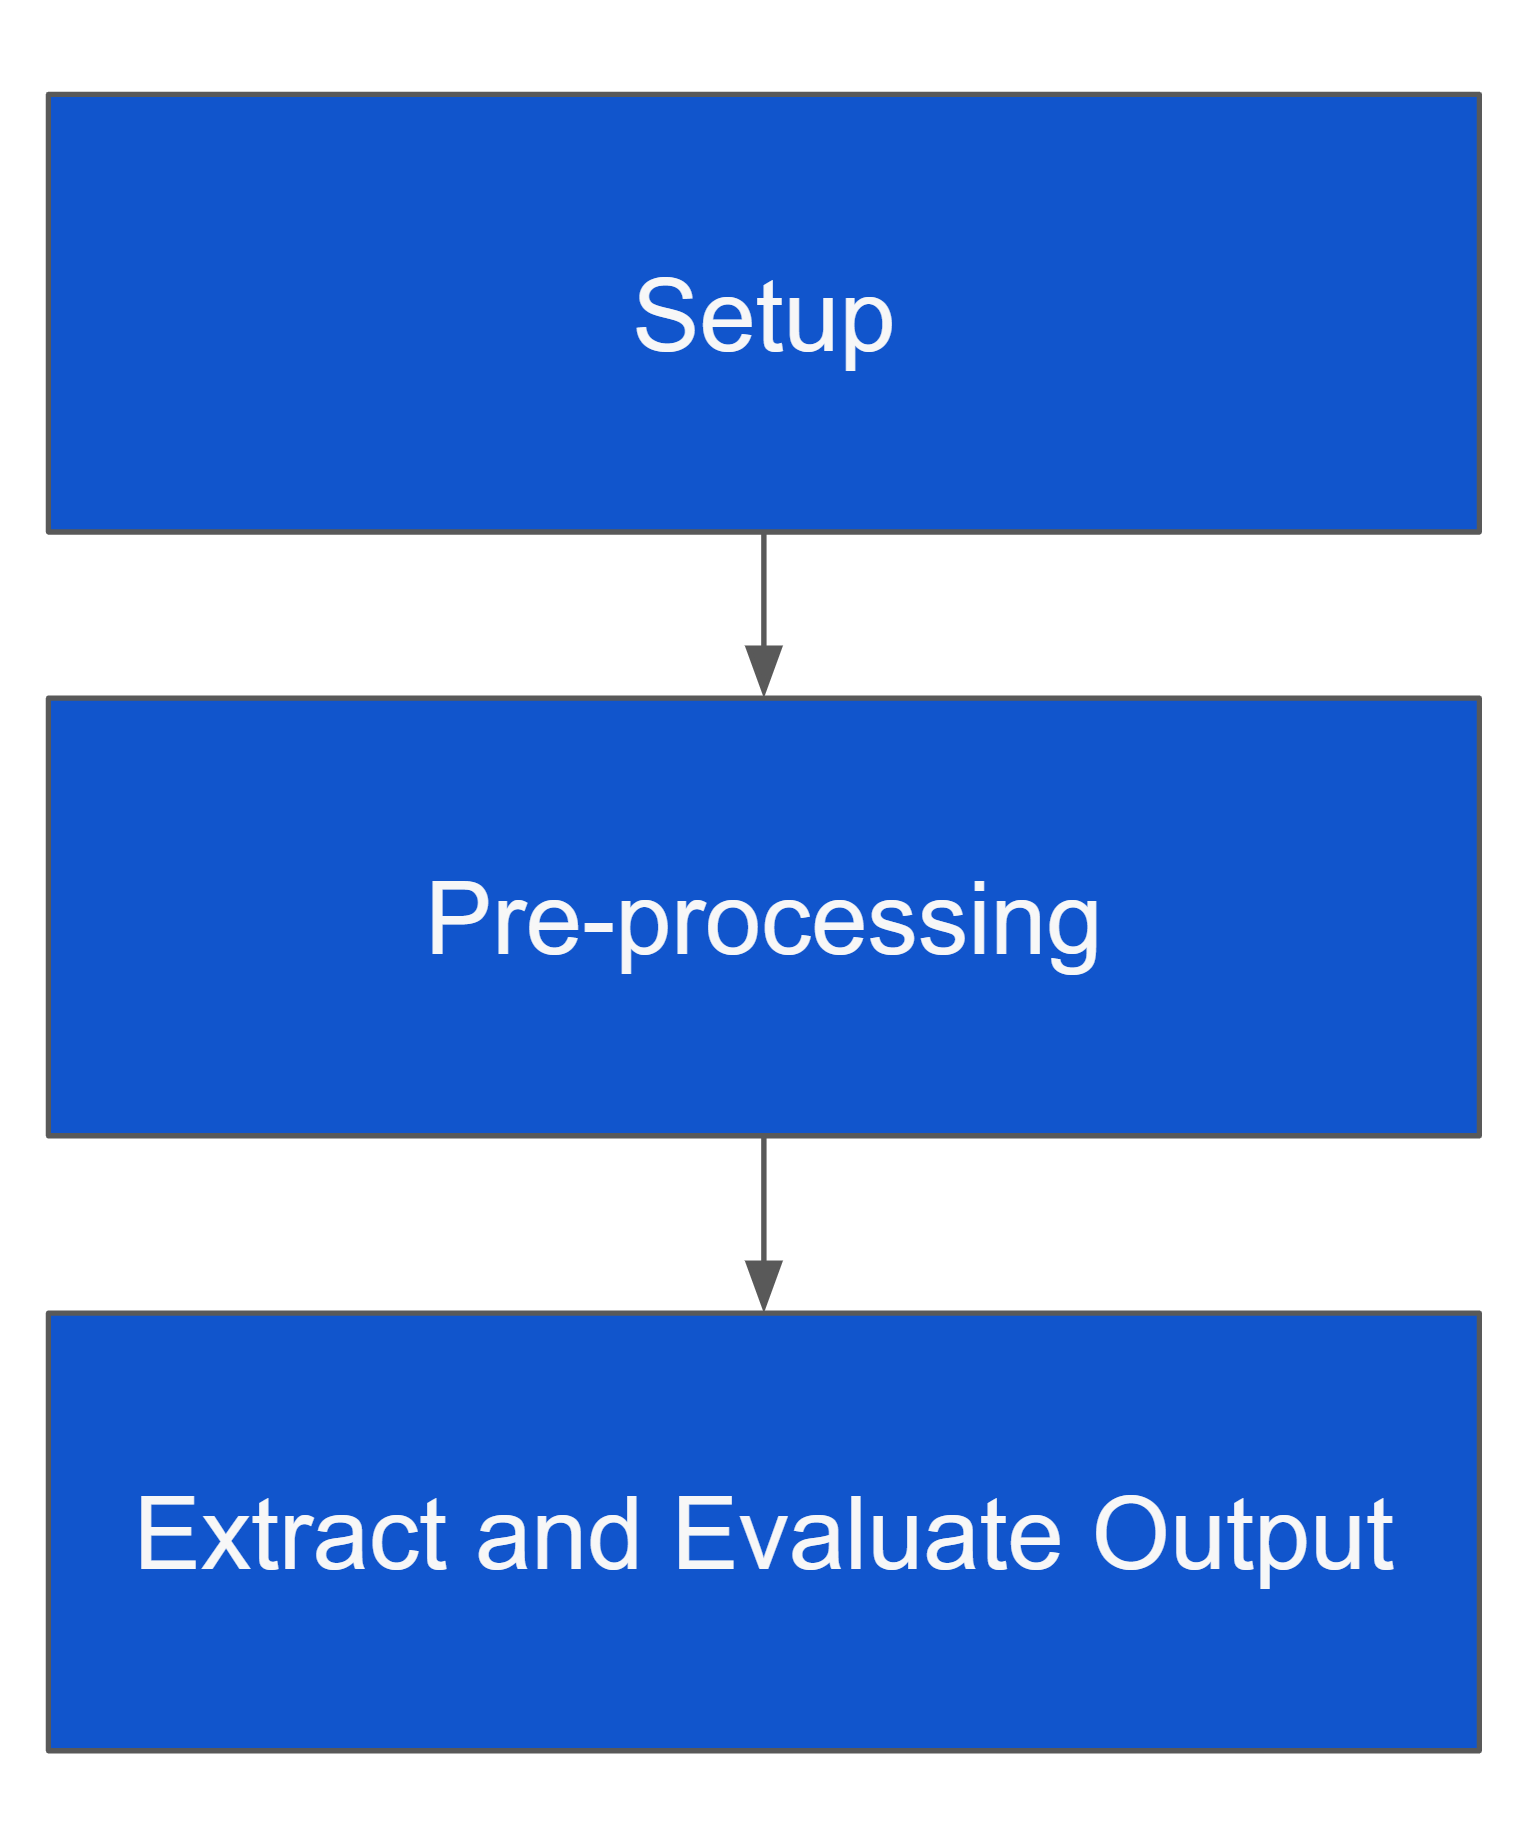</p>

## **1. Setup**

###**Steps:**

1.1 Installation and Import

1.2 Authentication

<p align="right">
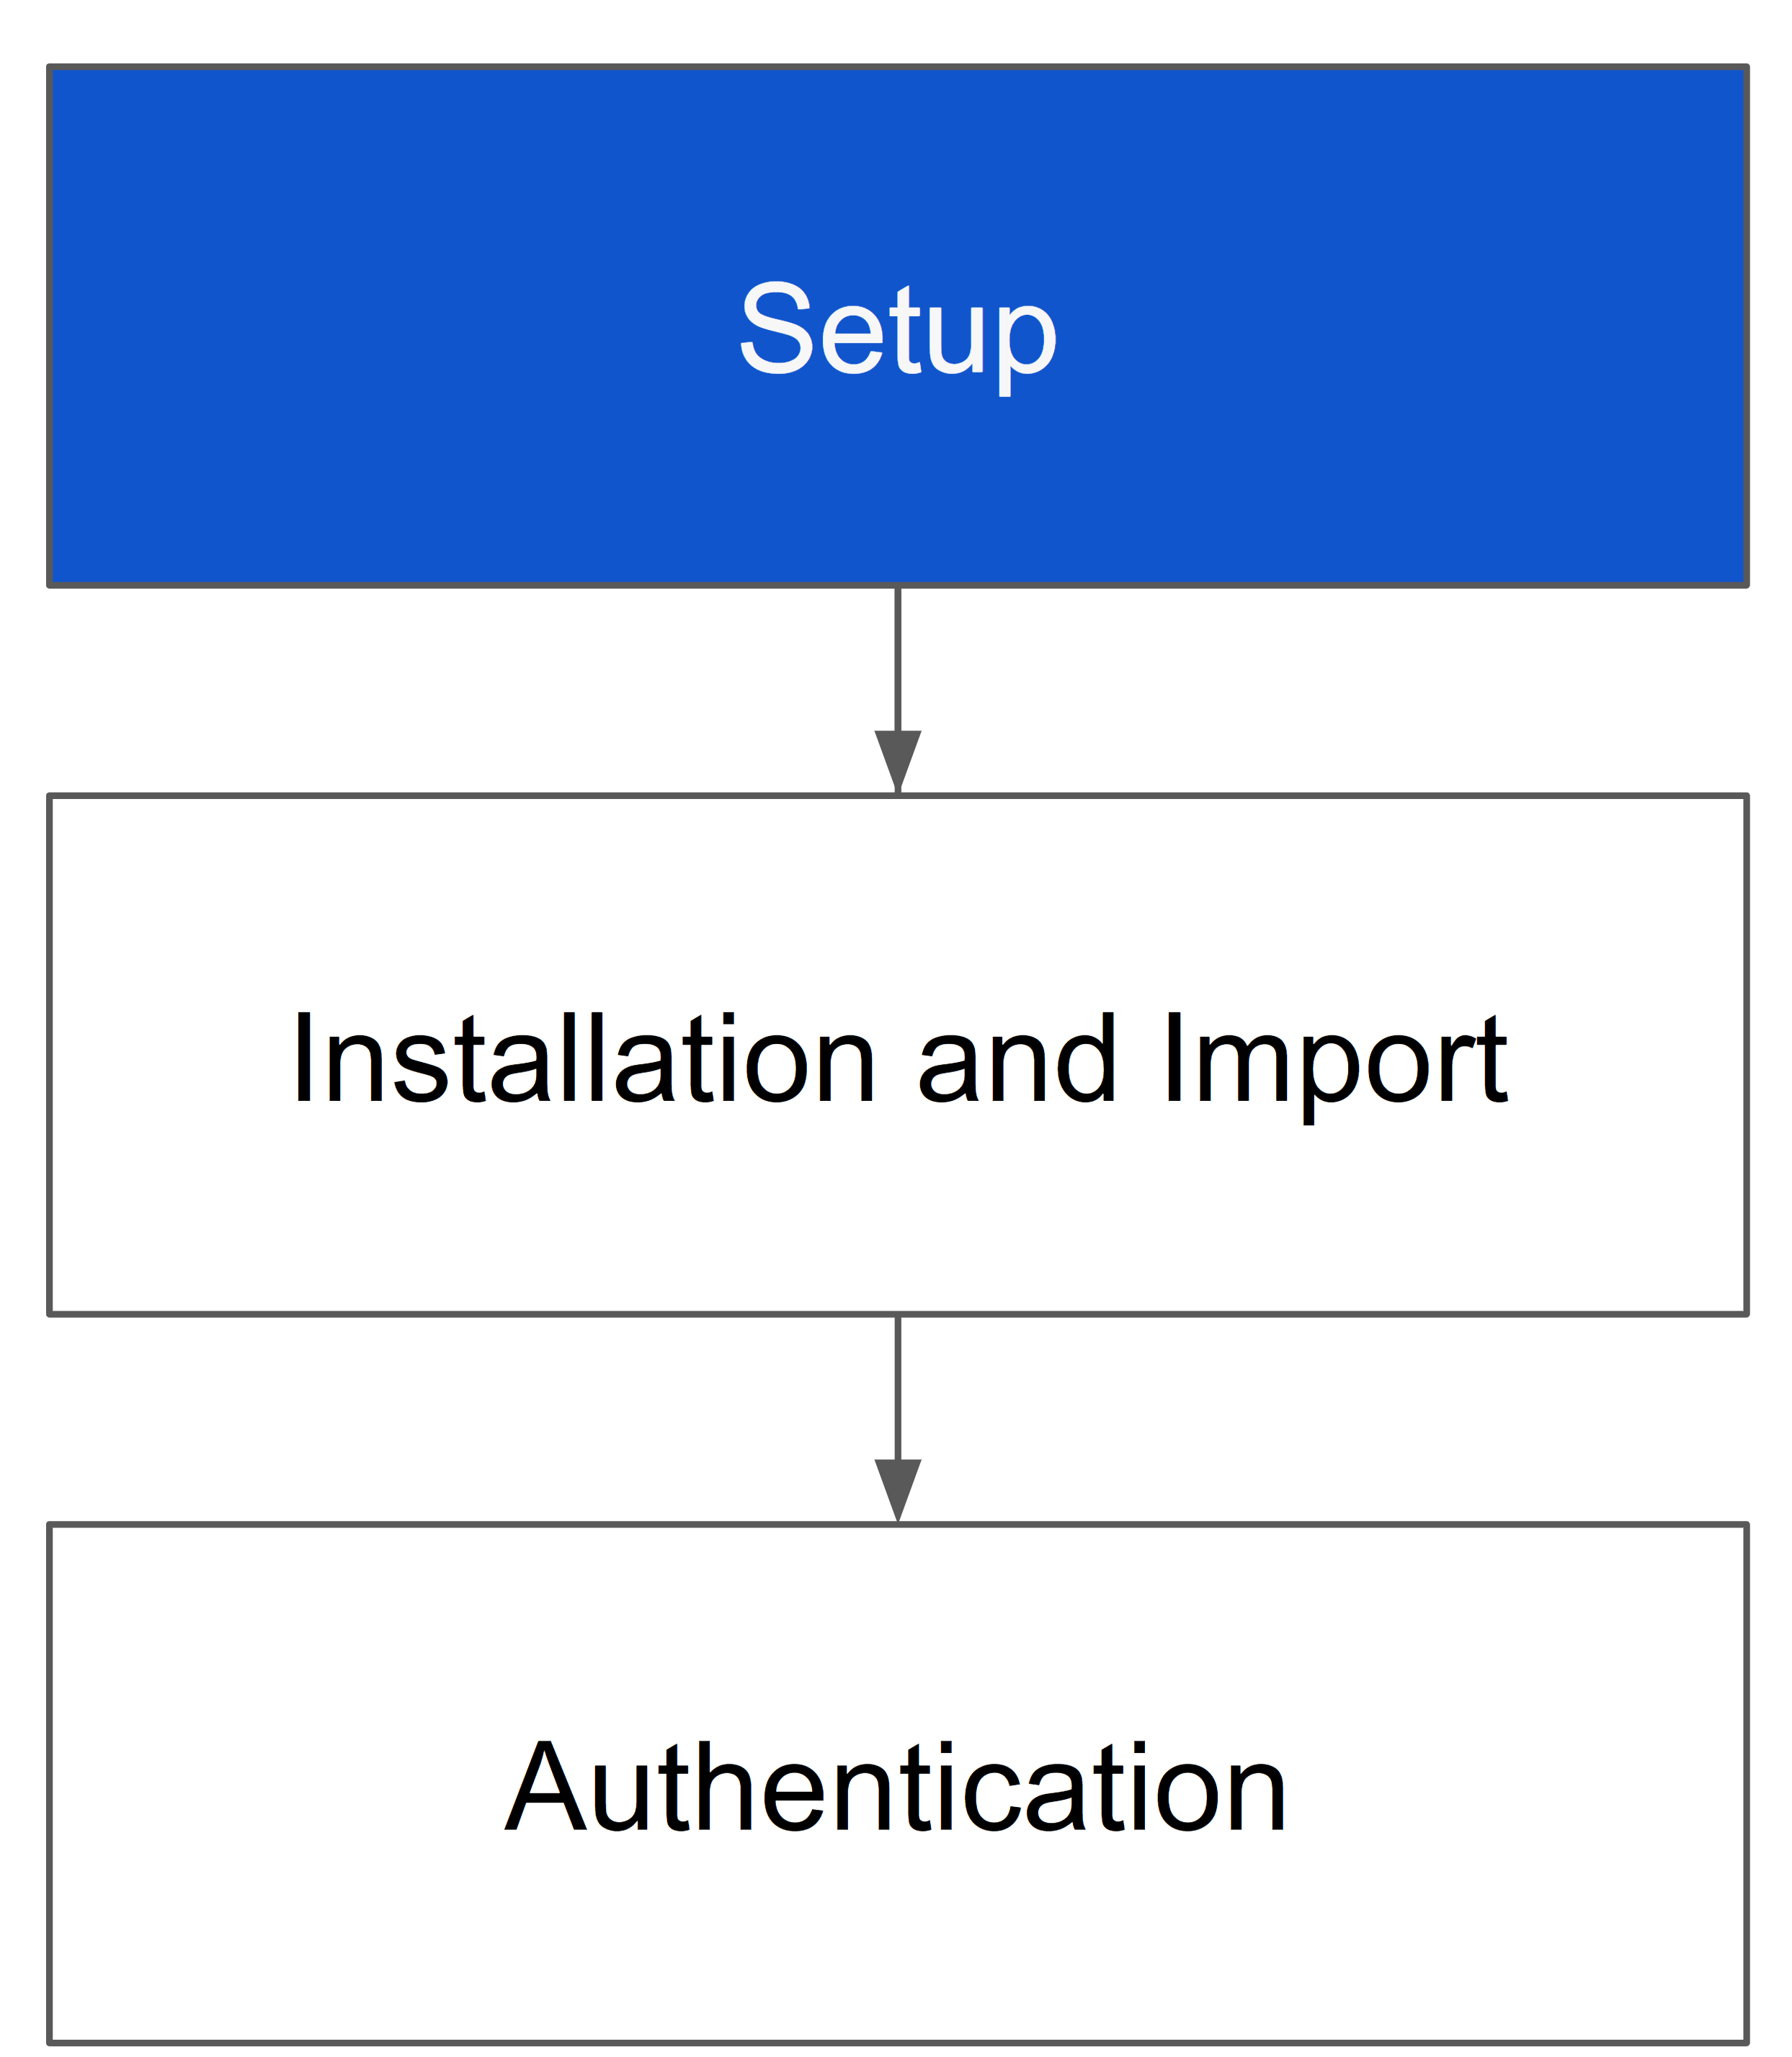</p>

###**1.1 Installation and import**

In [1]:
!pip install -q openai==1.55.3 datasets evaluate rouge_score bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.9/219.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
from openai import AzureOpenAI
from datasets import load_dataset
from evaluate import load
from tqdm import tqdm
import json

###**1.2 Authentication**

In [4]:
with open('config.json', 'r') as az_creds:
    data = az_creds.read()

In [5]:
data

'{\n    "AZURE_OPENAI_KEY": "346ebbcb19444213b6f9de2218df6ef8",\n    "AZURE_OPENAI_ENDPOINT": "https://jalajtest.openai.azure.com/",\n    "AZURE_OPENAI_APIVERSION": "2024-02-15-preview",\n    "CHATGPT_MODEL": "MLS"\n}'

In [6]:
creds = json.loads(data)

In [7]:
client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)

In [8]:
deployment_name = creds["CHATGPT_MODEL"]

## **2. Pre-processing**

###**Steps:**

2.1 Load Data

2.2 Verify Data

2.3 Devise Prompt

2.4 Create Prompt

<p align="right">
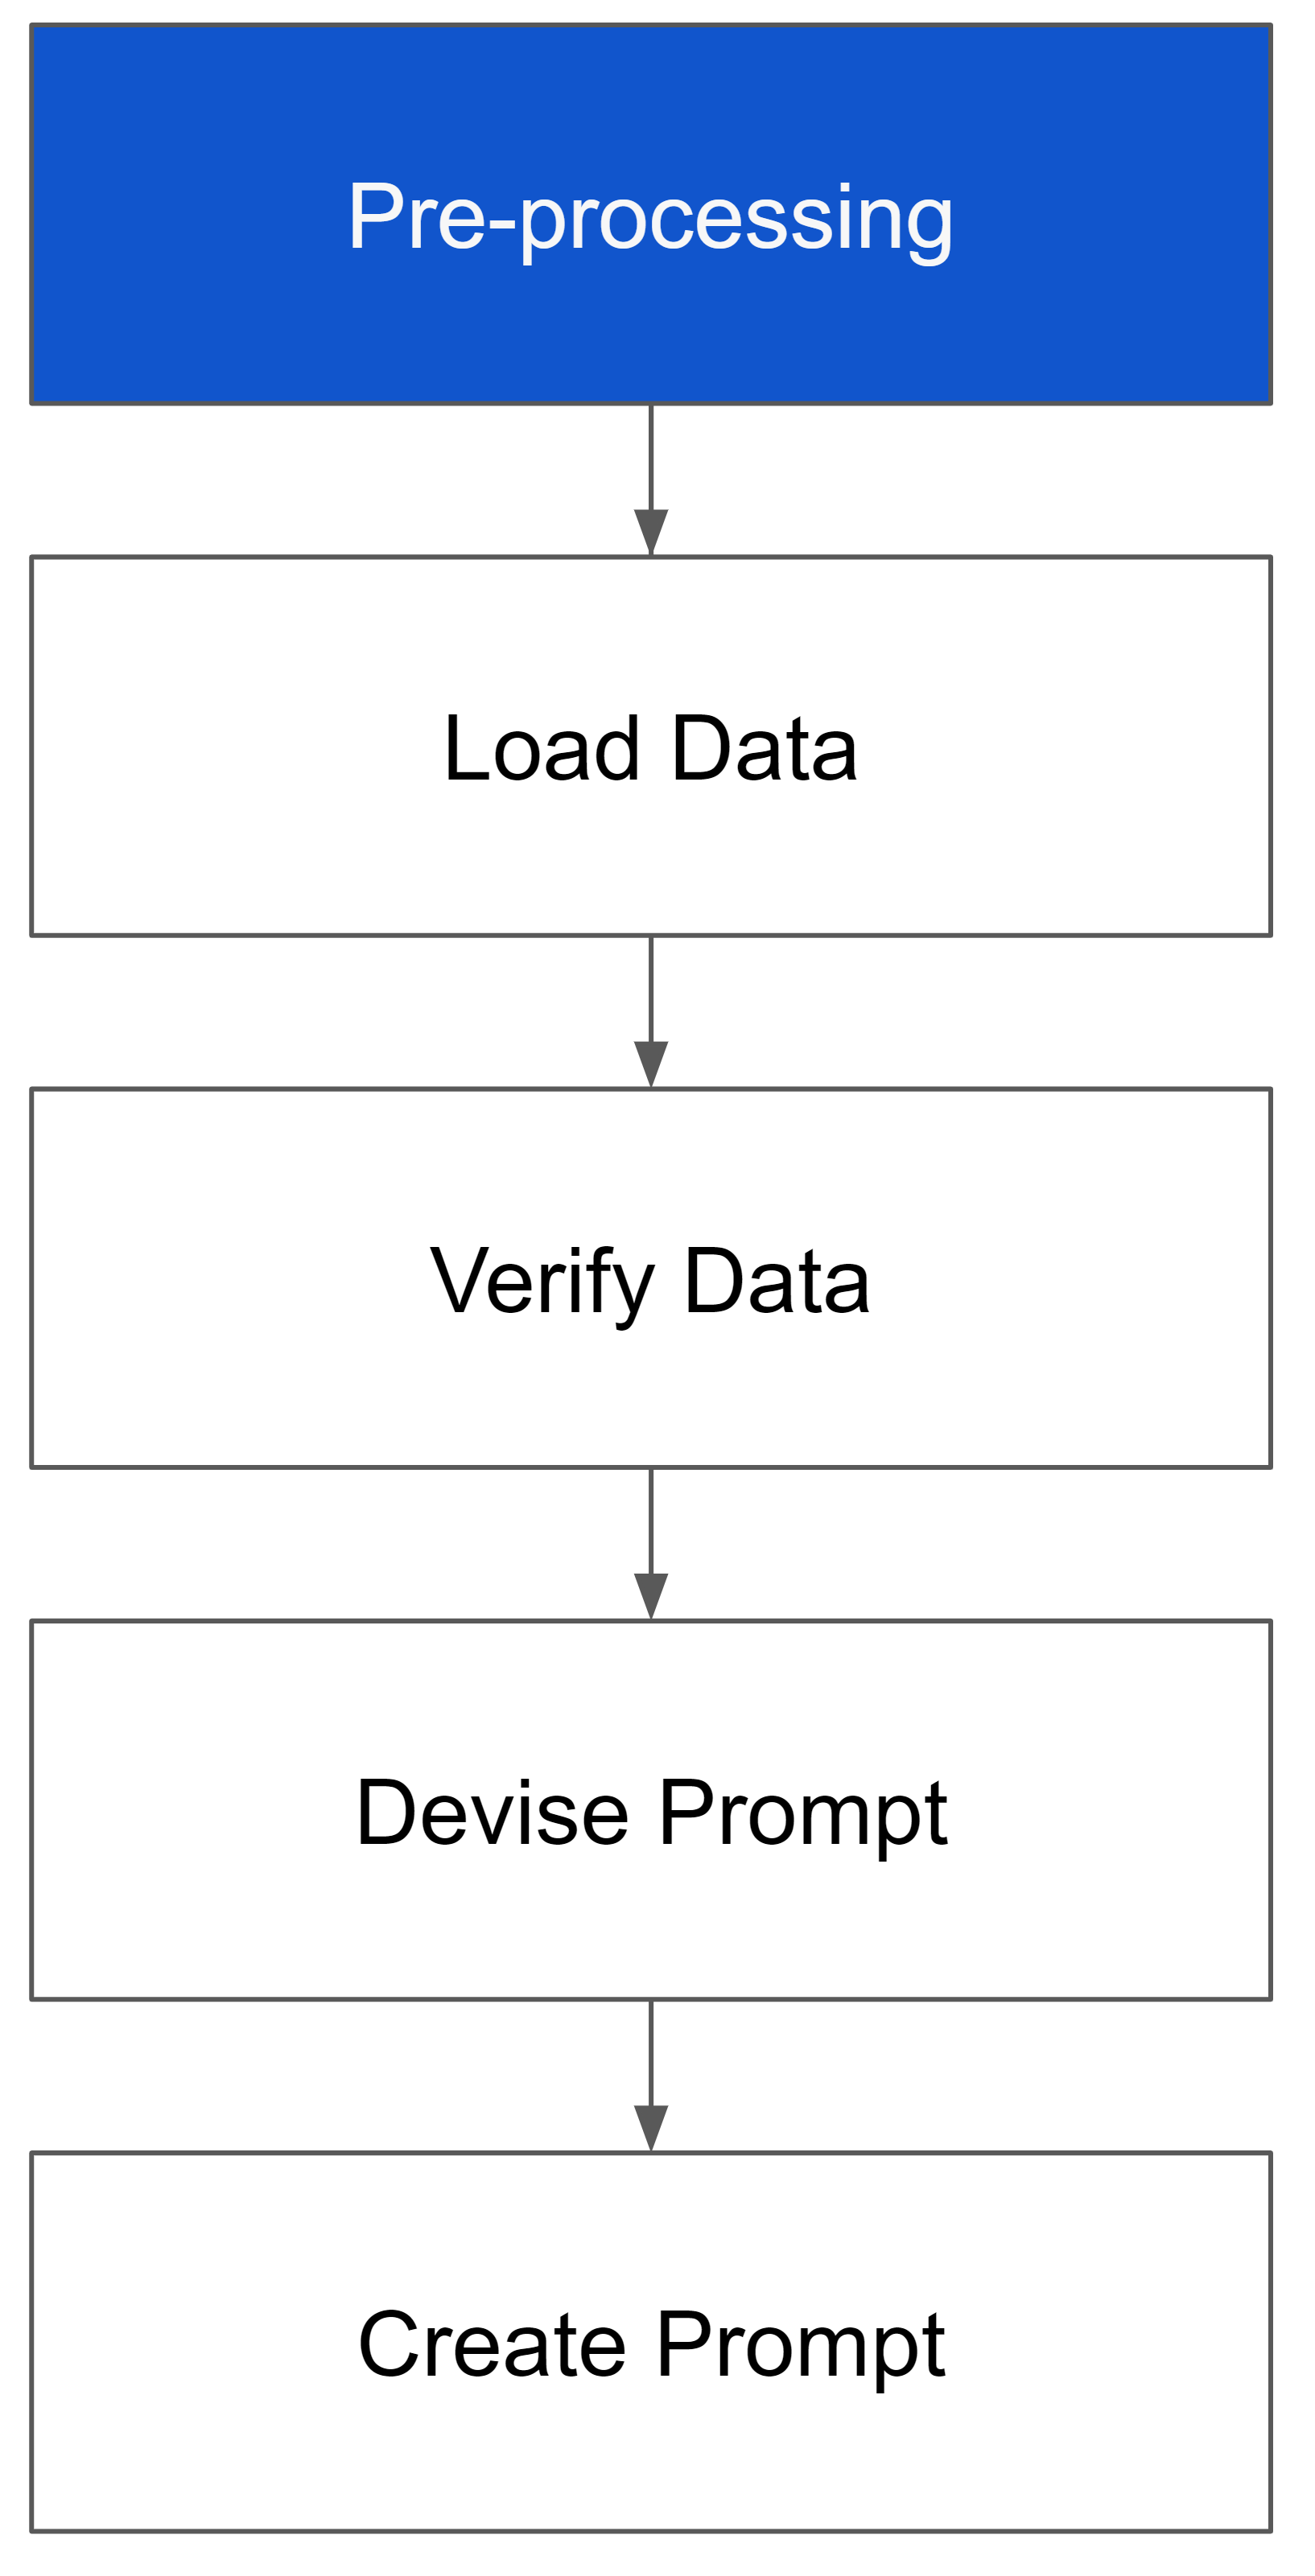 </p>

###**2.1 Load Data**

In [9]:
dataset = load_dataset("pgurazada1/dialogsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

In [10]:
dialogue_summary_examples_df = dataset['examples'].to_pandas()
dialogue_summary_gold_examples_df = dataset['gold_examples'].to_pandas()

In [11]:
examples_df = dialogue_summary_examples_df.sample(4)

In [12]:
examples_df

,dialogue,summary
29,#Person1#: Are you free on the thirteenth in t...,#Person1# and #Person2# are arranging for thei...
9,#Person1#: Hello. May I help you?\n#Person2#: ...,#Person2# checks the arrival of #Person2#'s co...
20,"#Person1#: Good afternoon. I am Mr. Brown, the...",It has been the fourth time for Mr. Brown to t...
0,#Person1#: Have you gone to school today?\n#Pe...,#Person1# couldn't go to school for the illnes...


###**2.2 Verify Data**

In [13]:
for index, row in examples_df.iterrows():
    print('Example Dialogue:')
    print(row[0])
    print('Example Summary:')
    print(row[1])
    break

Example Dialogue:
#Person1#: Are you free on the thirteenth in the afternoon?
#Person2#: No I'm afraid not. I'm meeting Ruth then. How about the fourteenth in the morning?
#Person1#: I'm sorry. I'm attending a meeting at the Hilton then.
#Person2#: What about the next day?
#Person1#: No. I'm busy then too. I'm meeting Dorothy Heath at North Bridge Road. Are you free on Thursday afternoon?
#Person2#: Yes, I think I am. Let's meet for lunch at mouth restaurant.
#Person1#: Good idea! Is two o'clock okay?
#Person2#: That's fine. See you there!
Example Summary:
#Person1# and #Person2# are arranging for their next meeting. They decide to meet on Thursday afternoon.


###**2.3 Devise Prompt**

In [14]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

In [15]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

###**2.4 Create Prompt**

In [16]:
for index, row in examples_df.iterrows():
    user_input_example = row[0]
    assistant_output_example = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [17]:
few_shot_prompt

[{'role': 'system',
  'content': '\nSummarize the dialogue mentioned in the user input. Be specific and concise in your summary.\n'},
 {'role': 'user',
  'content': "#Person1#: Are you free on the thirteenth in the afternoon?\n#Person2#: No I'm afraid not. I'm meeting Ruth then. How about the fourteenth in the morning?\n#Person1#: I'm sorry. I'm attending a meeting at the Hilton then.\n#Person2#: What about the next day?\n#Person1#: No. I'm busy then too. I'm meeting Dorothy Heath at North Bridge Road. Are you free on Thursday afternoon?\n#Person2#: Yes, I think I am. Let's meet for lunch at mouth restaurant.\n#Person1#: Good idea! Is two o'clock okay?\n#Person2#: That's fine. See you there!"},
 {'role': 'assistant',
  'content': '#Person1# and #Person2# are arranging for their next meeting. They decide to meet on Thursday afternoon.'},
 {'role': 'user',
  'content': "#Person1#: Hello. May I help you?\n#Person2#: Hi. Last month, our company, Turner Interiors of Beijing, ordered some do

## **3. Extract and Evaluate Output**

###**Steps:**

3.1 Extract results

3.2 Evaluate results

<p align="right">
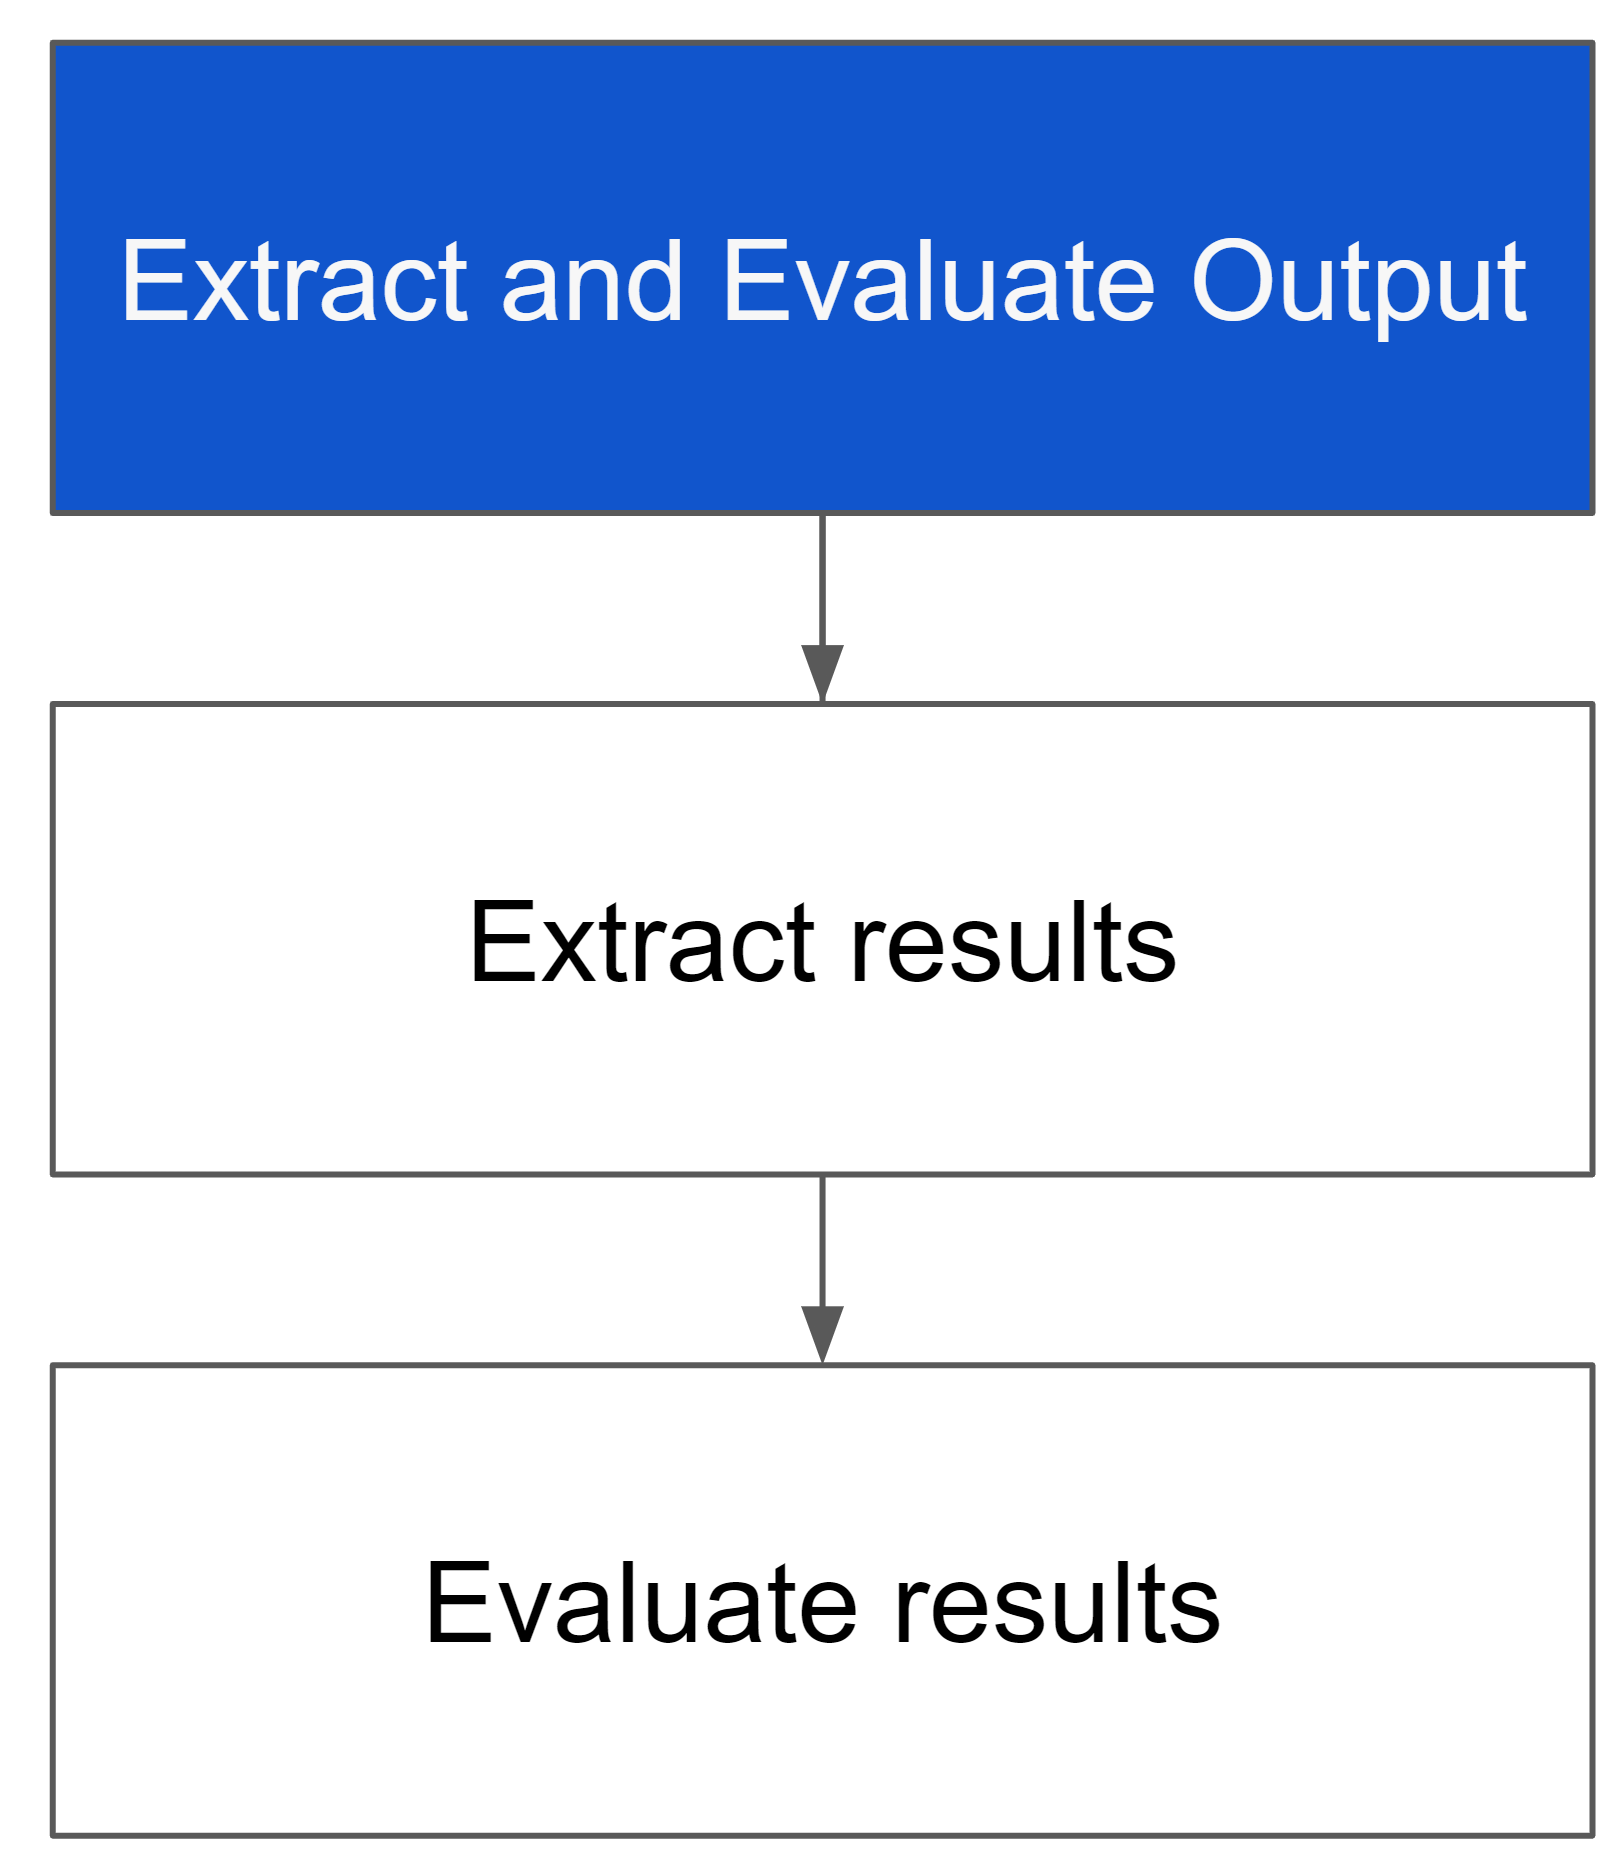 </p>

###**3.1 Extract results**

In [18]:
predictions, ground_truths = [], []

In [19]:
for index, row in tqdm(dialogue_summary_gold_examples_df.iterrows()):
    gold_dialogue = row[0]
    gold_summary = row[1]

    user_input = [{'role':'user', 'content': gold_dialogue}]

    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=few_shot_prompt + user_input
        )

        predictions.append(response.choices[0].message.content)
        ground_truths.append(gold_summary)
    except Exception as e:
        print(e) # Log error and continue
        continue

32it [00:32,  1.01s/it]


In [20]:
predictions

['#Person1# suggests making dinner together instead of a frozen pizza. They agree to make the spicy chicken curry. #Person2# shows difficulties with cooking, but #Person1# offers to teach. They start with washing and chopping vegetables, stir-frying them, cutting and stir-frying chicken before cooking rice along with it. #Person2# prefers white rice.',
 '#Person1# and #Person2# discuss their interest in art and plan to visit the national gallery for a Greek and Roman sculpture exhibition together.',
 'Tom has written a letter to Sally and John. It was good for Tom to hear about their upcoming visit in January. Tom has invited them for dinner and also shared his phone number.',
 "#Person1# is telling #Person2# about #Person1#'s New Year's resolution, which is going on a diet without eating junk food. However, at the end #Person1# asked #Person2# if they have any chips left.",
 '#Person1# has a reservation note and wants to pick up the ticket. #Person2# asks #Person1# to fill out the tic

###**3.2 Evaluate results**

In [21]:
rouge_scorer = load("rouge")
bertscore = load("bertscore")

In [22]:
rouge_scorer.compute(
            predictions=predictions,
            references=ground_truths,
        )

{'rouge1': 0.32320128991068914,
 'rouge2': 0.09956898499591577,
 'rougeL': 0.24663161906585995,
 'rougeLsum': 0.2468748685265108}

In [23]:
results = bertscore.compute(
    predictions=predictions,
    references=ground_truths,
    lang="en"
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
sum(results['f1'])/len(results['f1'])

0.8971373289823532